# Week 7 - Information Extraction


This week, we move from arbitrary textual classification to the use of computation and linguistic models to parse precise claims from documents. Rather than focusing on simply the *ideas* in a corpus, here we focus on understanding and extracting its precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases, like the Subject-Verb-Object (SVO) triples we extract here. While much of this can be done directly in the python package NLTK that we introduced in week 2, here we use NLTK bindings to the Stanford NLP group's open software, written in Java. Try typing a sentence into the online version [here](http://nlp.stanford.edu:8080/corenlp/) to get a sense of its potential. It is superior in performance to NLTK's implementations, but takes time to run, and so for these exercises we will parse and extract information for a very small text corpus. Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text. 

For this notebook we will be using the following packages:

In [82]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
#For NLP
import nltk

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile
import re
import lucem_illud.stanford as stanford
%matplotlib inline

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional frequencies (e.g., adjectives associated with nouns of interest or adverbs with verbs of interest). What do these distributions suggest about your corpus?

In [84]:
targetDir = 'C:/Users/hankanyao/Documents/content-analysis-2018/sentence'
platoText = []
platoFileName = []

for file in (file for file in os.scandir(targetDir) if file.is_file() and not file.name.startswith('.')):
    with open(file.path, encoding = 'latin-1') as f:
        platoText.append(f.read())
    platoFileName.append(file.name)

paragraph = pandas.DataFrame({'text' : platoText})
remove = np.array([r'\[\d+\]', r'\(\d+\)', '\n', '\t', '\d+', r'\(\w+\)'])
for i in range(paragraph.shape[0]):
    for j in range(len(remove)):
        paragraph["text"].iloc[i] = re.sub(remove[j], ' ', paragraph["text"].iloc[i])
paragraph

,text
0,In reality I had set my heart at that time on ...
1,The method of this man is quite contrary to th...
2,Which of them has been provisionally victoriou...
3,This is simply the long history of the origin ...
4,"Entertaining, as I do, these thoughts, I am, l..."
5,"Undoubtedly the bad conscience is an illness, ..."
6,What is the meaning of ascetic ideals? In arti...
7,"And now, after we have caught sight of the _as..."
8,When he has to tackle sufferers of the lower o...


In [85]:
import os
java_path = "F:/java/bin/java.exe"
os.environ['JAVAHOME'] = java_path
paragraph['tokenized'] = paragraph['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
paragraph['POS_sents'] = paragraph['tokenized'].apply(lambda x: stanford.postTagger.tag_sents(x))

In [86]:
paragraph['POS_sents'] 

0    [[(In, IN), (reality, NN), (I, PRP), (had, VBD...
1    [[(The, DT), (method, NN), (of, IN), (this, DT...
2    [[(Which, WDT), (of, IN), (them, PRP), (has, V...
3    [[(This, DT), (is, VBZ), (simply, RB), (the, D...
4    [[(Entertaining, JJ), (,, ,), (as, IN), (I, PR...
5    [[(Undoubtedly, NNP), (the, DT), (bad, JJ), (c...
6    [[(What, WP), (is, VBZ), (the, DT), (meaning, ...
7    [[(And, CC), (now, RB), (,, ,), (after, IN), (...
8    [[(When, WRB), (he, PRP), (has, VBZ), (to, TO)...
Name: POS_sents, dtype: object

In [87]:
countTarget = 'NN'
targetCounts = {}
for entry in paragraph['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
print(sortedTargets[:20])

[(')', 56), ('man', 54), ('(', 42), ('life', 42), ('time', 23), ('world', 20), ('fact', 18), ('morality', 17), ('power', 17), ('existence', 17), ('value', 15), ('will', 15), ('idea', 15), ('one', 14), ('reason', 14), ('question', 13), ('ideal', 13), ('point', 12), ('meaning', 12), ('conscience', 12)]


In [89]:
countTarget = 'VB'
targetCounts = {}
for entry in paragraph['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
print(sortedTargets[:20])

[('be', 67), ('have', 16), ('let', 12), ('do', 11), ('say', 6), ('know', 6), ('consider', 5), ('think', 5), ('make', 5), ('turn', 5), ('give', 4), ('take', 4), ('come', 4), ('see', 4), ('put', 3), ('get', 3), ('regard', 3), ('serve', 3), ('look', 3), ('grow', 3)]


In [111]:
NTarget = 'JJ'
Word = 'conscience'
NResults = set()
for entry in paragraph['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)

{'bad', 'beast-of-prey', 'hypocritical'}


## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed (using your own hand-codings as "ground truth").

In [103]:
classified_sents = stanford.nerTagger.tag_sents(tokenized_text)
paragraph['classified_sents'] = paragraph['tokenized'].apply(lambda x: stanford.nerTagger.tag_sents(x))

In [104]:
paragraph['classified_sents']

0    [[(In, O), (reality, O), (I, O), (had, O), (se...
1    [[(The, O), (method, O), (of, O), (this, O), (...
2    [[(Which, O), (of, O), (them, O), (has, O), (b...
3    [[(This, O), (is, O), (simply, O), (the, O), (...
4    [[(Entertaining, O), (,, O), (as, O), (I, O), ...
5    [[(Undoubtedly, O), (the, O), (bad, O), (consc...
6    [[(What, O), (is, O), (the, O), (meaning, O), ...
7    [[(And, O), (now, O), (,, O), (after, O), (we,...
8    [[(When, O), (he, O), (has, O), (to, O), (tack...
Name: classified_sents, dtype: object

In [105]:
entityCounts = {}
for entry in paragraph['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[(',', 1045),
 ('the', 828),
 ('of', 607),
 ('and', 353),
 ('to', 313),
 ('a', 253),
 ('in', 236),
 ('.', 201),
 ('is', 195),
 ('that', 173)]

In [106]:
[x[0] for x in sortedEntities if x[1] == 2]

['heart',
 'important',
 'issue',
 'passion',
 'turned',
 'colours',
 'negation',
 'soul',
 'dug',
 'deeper',
 'sublime',
 'temptation',
 '_against_',
 'melancholy',
 'realised',
 'wider',
 'phenomenon',
 'Kant',
 'minds',
 'different',
 'contempt',
 'immense',
 'potentiality',
 'Let',
 'values_',
 'circumstances',
 'misunderstanding',
 'neither',
 'nor',
 'indisputable',
 'specifically',
 'progress',
 'Suppose',
 'converse',
 'method',
 'unsatisfied',
 'act',
 'conception',
 'spite',
 'asked',
 'Who',
 'rules',
 'distorted',
 'deny',
 'ones',
 '_inter',
 'pares_',
 'kept',
 'mutual',
 'jealousy',
 'ways',
 'begins',
 'enjoy',
 'feel',
 'wilderness',
 'vent',
 'tension',
 'produced',
 'beast-of-prey',
 'ghastly',
 'torture',
 'merely',
 'poets',
 'ample',
 'theme',
 'magnificent',
 'return',
 'Roman',
 'nobility',
 'Homeric',
 'manifests',
 'Pericles',
 'says',
 'Athenians',
 'Our',
 'audacity',
 'absurd',
 'glory',
 'delight',
 'destruction',
 'picture',
 'enemy',
 'icy',
 'inextingui

In [113]:
nonObjCounts = {}
for entry in paragraph['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'O':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

[('Wagner', 10),
 ('Rome', 7),
 ('Schopenhauer', 4),
 ('Plato', 4),
 ('Europe', 4),
 ('Judæa', 3),
 ('Richard', 3),
 ('Kant', 2),
 ('Pericles', 2),
 ('Jesus', 2)]

In [115]:
OrgCounts = {}
for entry in paragraph['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'ORGANIZATION':
                continue
            elif ent in OrgCounts:
                OrgCounts[ent] += 1
            else:
                OrgCounts[ent] = 1
sortedOrgs = sorted(OrgCounts.items(), key = lambda x: x[1], reverse = True)
sortedOrgs[:10]

[('Spinoza', 1),
 ('Hesiod', 1),
 ('Church', 1),
 ('Heracles', 1),
 ('Vedanta', 1),
 ('Philosophy', 1),
 ('Plato', 1),
 ('Catholic', 1),
 ('Protestant', 1)]

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceived to play in the social world inscribed by your texts?

In [119]:
def treeRelation(parsetree, relationType, *targets):
    if isinstance(parsetree, list):
        parsetree = parsetree[0]
    if set(targets) & set(parsetree.leaves()) != set(targets):
        return []
    else:
        retList = []
        for subT in parsetree.subtrees():
            if subT.label() == relationType:
                if set(targets) & set(subT.leaves()) == set(targets):
                    retList.append([(subT.label(), ' '.join(subT.leaves()))])
    return retList

In [120]:
def treeSubRelation(parsetree, relationTypeScope, relationTypeTarget, *targets):
    if isinstance(parsetree, list):
        parsetree = parsetree[0]
    if set(targets) & set(parsetree.leaves()) != set(targets):
        return []
    else:
        retSet = set()
        for subT in parsetree.subtrees():
            if set(targets) & set(subT.leaves()) == set(targets):
                if subT.label() == relationTypeScope:
                    for subsub in subT.subtrees():
                        if subsub.label()==relationTypeTarget:
                            retSet.add(' '.join(subsub.leaves()))
    return retSet

In [118]:
parses = list(stanford.parser.parse_sents(paragraph["tokenized"][2])) #Converting the iterator to a list so we can call by index. They are still 
fourthSentParseTree = list(parses[3]) #iterators so be careful about re-running code, without re-running this block
print(fourthSentParseTree)

[Tree('ROOT', [Tree('S', [Tree('S', [Tree('PP', [Tree('IN', ['At']), Tree('NP', [Tree('DT', ['any']), Tree('NN', ['rate'])])]), Tree('NP', [Tree('EX', ['there'])]), Tree('VP', [Tree('VBD', ['took']), Tree('NP', [Tree('NP', [Tree('NN', ['place'])]), Tree('PP', [Tree('IN', ['in']), Tree('NP', [Tree('NP', [Tree('NP', [Tree('DT', ['the']), Tree('NNP', ['Renaissance'])]), Tree('NP', [Tree('NP', [Tree('DT', ['a']), Tree('JJ', ['brilliantly']), Tree('JJ', ['sinister']), Tree('NN', ['revival'])]), Tree('PP', [Tree('IN', ['of']), Tree('NP', [Tree('DT', ['the']), Tree('JJ', ['classical']), Tree('NN', ['ideal'])])])])]), Tree(',', [',']), Tree('PP', [Tree('IN', ['of']), Tree('NP', [Tree('NP', [Tree('DT', ['the']), Tree('ADJP', [Tree('JJ', ['aristocratic'])]), Tree('NN', ['valuation'])]), Tree('PP', [Tree('IN', ['of']), Tree('NP', [Tree('DT', ['all']), Tree('NNS', ['things'])])])])]), Tree(':', [':']), Tree('NP', [Tree('NP', [Tree('NNP', ['Rome'])]), Tree('SBAR', [Tree('S', [Tree('NP', [Tree('PRP'

In [136]:
treeRelation(fourthSentParseTree, 'VP', 'Rome')

[[('VP',
   "took place in the Renaissance a brilliantly sinister revival of the classical ideal , of the aristocratic valuation of all things : Rome herself , like a man waking up from a trance , stirred beneath the burden of the new Judaised Rome that had been built over her , which presented the appearance of an \x9ccumenical synagogue and was called the `` Church '' :")],
 [('VP',
   "stirred beneath the burden of the new Judaised Rome that had been built over her , which presented the appearance of an \x9ccumenical synagogue and was called the `` Church ''")],
 [('VP',
   'triumphed again , thanks to that fundamentally popular German and English movement of revenge , which is called the Reformation , and taking also into account its inevitable corollary , the restoration of the Church -- the restoration also of the ancient graveyard peace of classical Rome')],
 [('VP',
   'is called the Reformation , and taking also into account its inevitable corollary , the restoration of the Ch

In [140]:
treeSubRelation(fourthSentParseTree, 'NP', 'NN', 'ancient')

{'corollary', 'graveyard', 'peace', 'restoration'}

In [141]:
fourthSentParseTree[0].pretty_print()

                                                                                                                                                                                                                                                                                                                                                                                                              ROOT                                                                                                                                                                                                                                                                                                                                                                                                                                
                                                                                                                                                                                     

In [144]:
depParses = list(stanford.depParser.raw_parse_sents(paragraph_text)) #Converting the iterator to a list so we can call by index. They are still 
secondSentDepParseTree = list(depParses[3])[0] #iterators so be careful about re-running code, without re-running this block
print(secondSentDepParseTree)

defaultdict(<function DependencyGraph.__init__.<locals>.<lambda> at 0x000001AFC294FA60>,
            {0: {'address': 0,
                 'ctag': 'TOP',
                 'deps': defaultdict(<class 'list'>, {'root': [5]}),
                 'feats': None,
                 'head': None,
                 'lemma': None,
                 'rel': None,
                 'tag': 'TOP',
                 'word': None},
             1: {'address': 1,
                 'ctag': 'IN',
                 'deps': defaultdict(<class 'list'>, {}),
                 'feats': '_',
                 'head': 3,
                 'lemma': '_',
                 'rel': 'case',
                 'tag': 'IN',
                 'word': 'At'},
             2: {'address': 2,
                 'ctag': 'DT',
                 'deps': defaultdict(<class 'list'>, {}),
                 'feats': '_',
                 'head': 3,
                 'lemma': '_',
                 'rel': 'det',
                 'tag': 'DT',
                

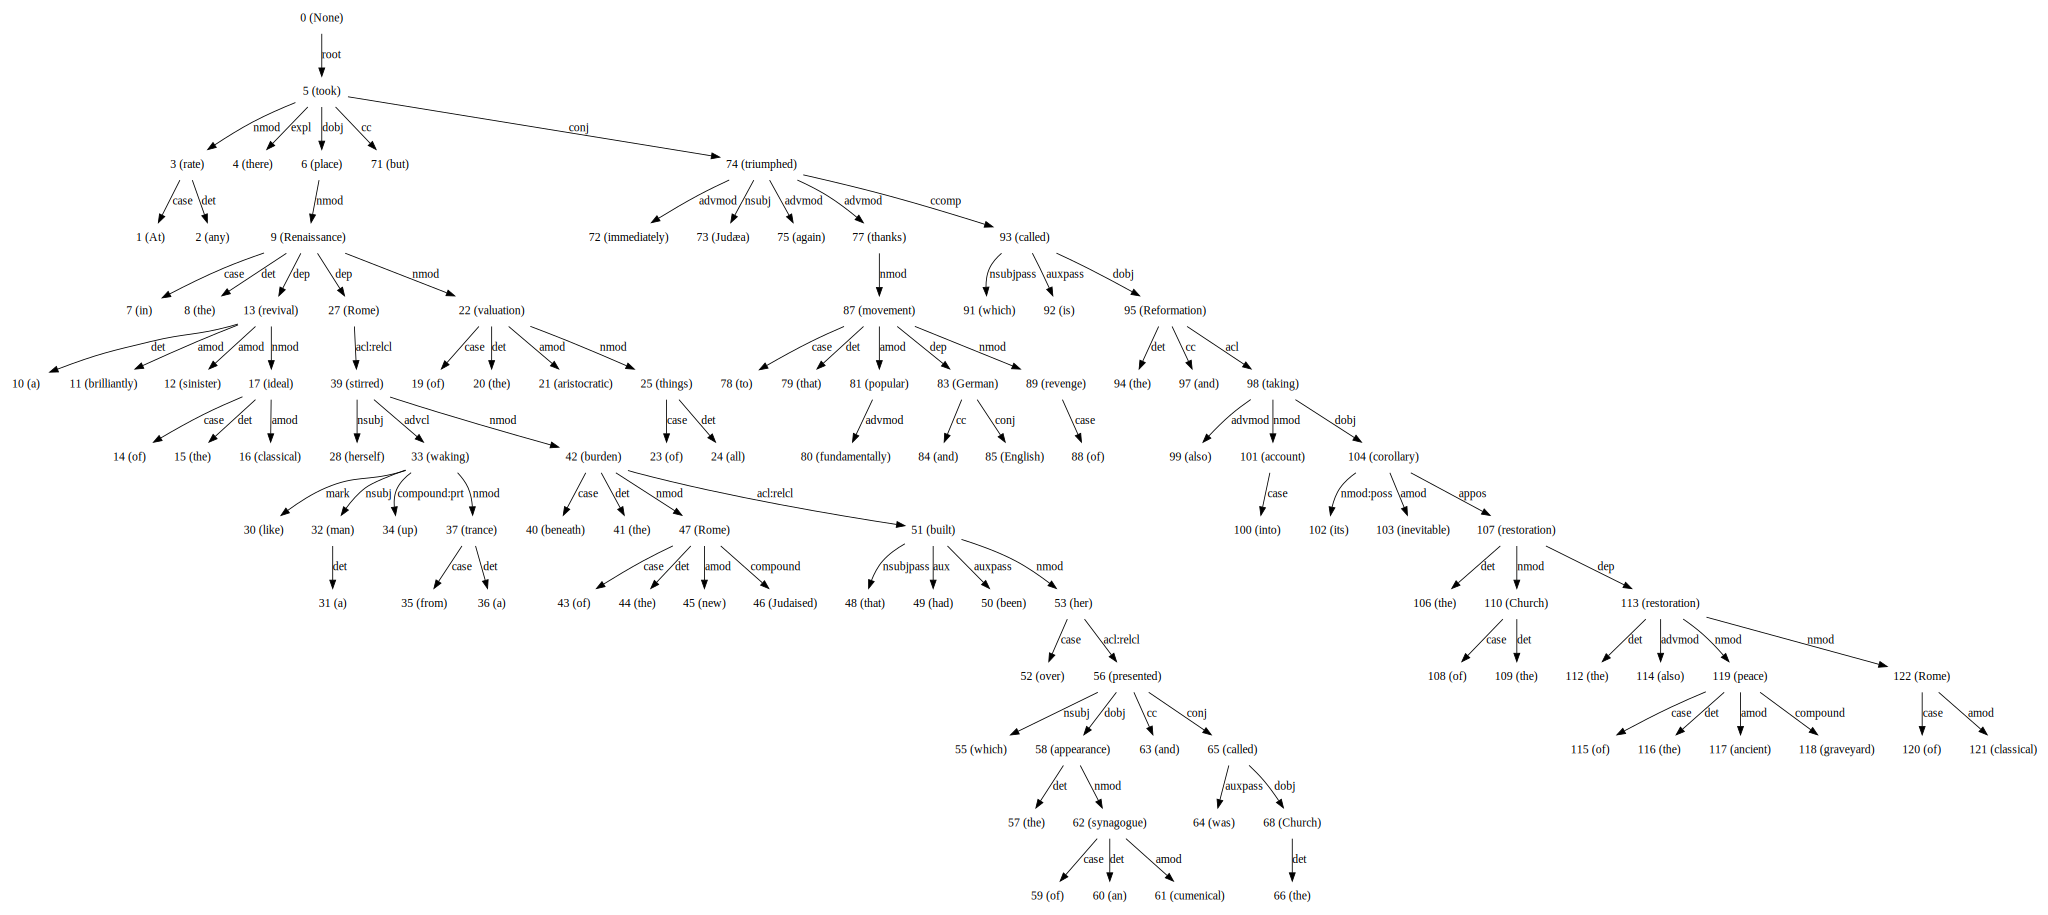

In [148]:
os.environ["PATH"] += os.pathsep + 'F:/graphviz/bin/'
try:
    secondSentGraph = graphviz.Source(secondSentDepParseTree.to_dot())
except:
    secondSentGraph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
secondSentGraph

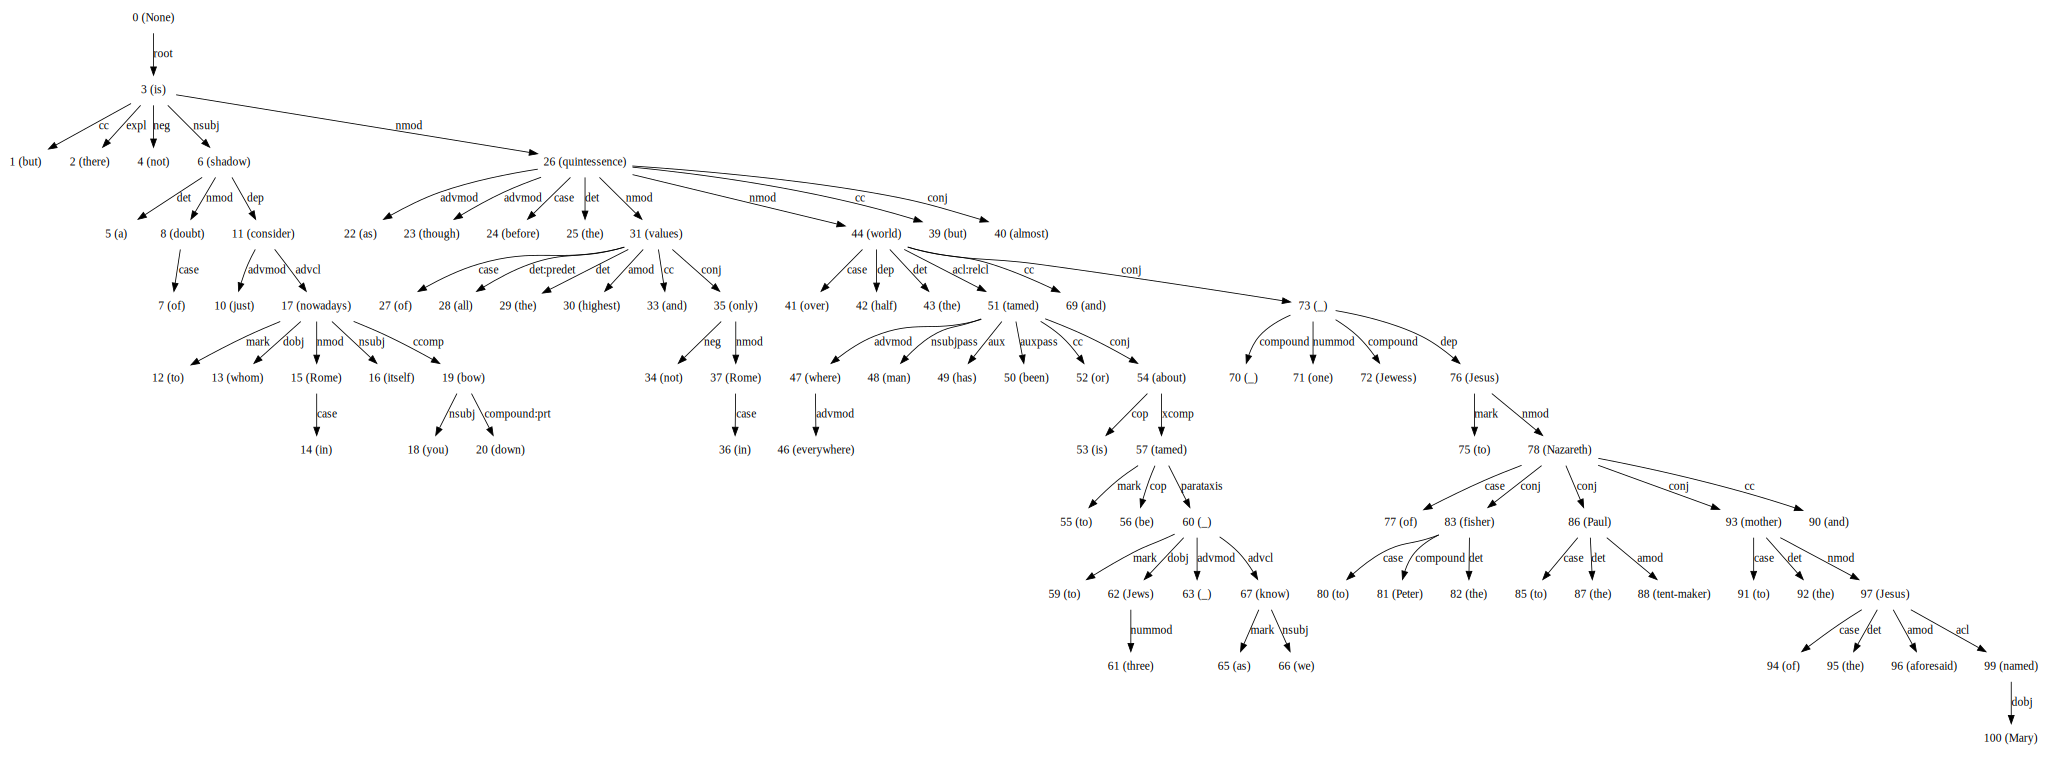

In [150]:
try:
    graph = graphviz.Source(list(depParses[1])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph

In [151]:
topPostDepParse = list(stanford.depParser.parse_sents(paragraph['tokenized'][0]))

In [158]:
targetSentence = 8
print(' '.join(paragraph['tokenized'][0][targetSentence]))

This problem of the value of pity and of the pity-morality ( I am an opponent of the modern infamous emasculation of our emotions ) seems at the first blush a mere isolated problem , a note of interrogation for itself ; he , however , who once halts at this problem , and learns how to put questions , will experience what I experienced : -- a new and immense vista unfolds itself before him , a sense of potentiality seizes him like a vertigo , every species of doubt , mistrust , and fear springs up , the belief in morality , nay , in all morality , totters , -- finally a new demand voices itself .


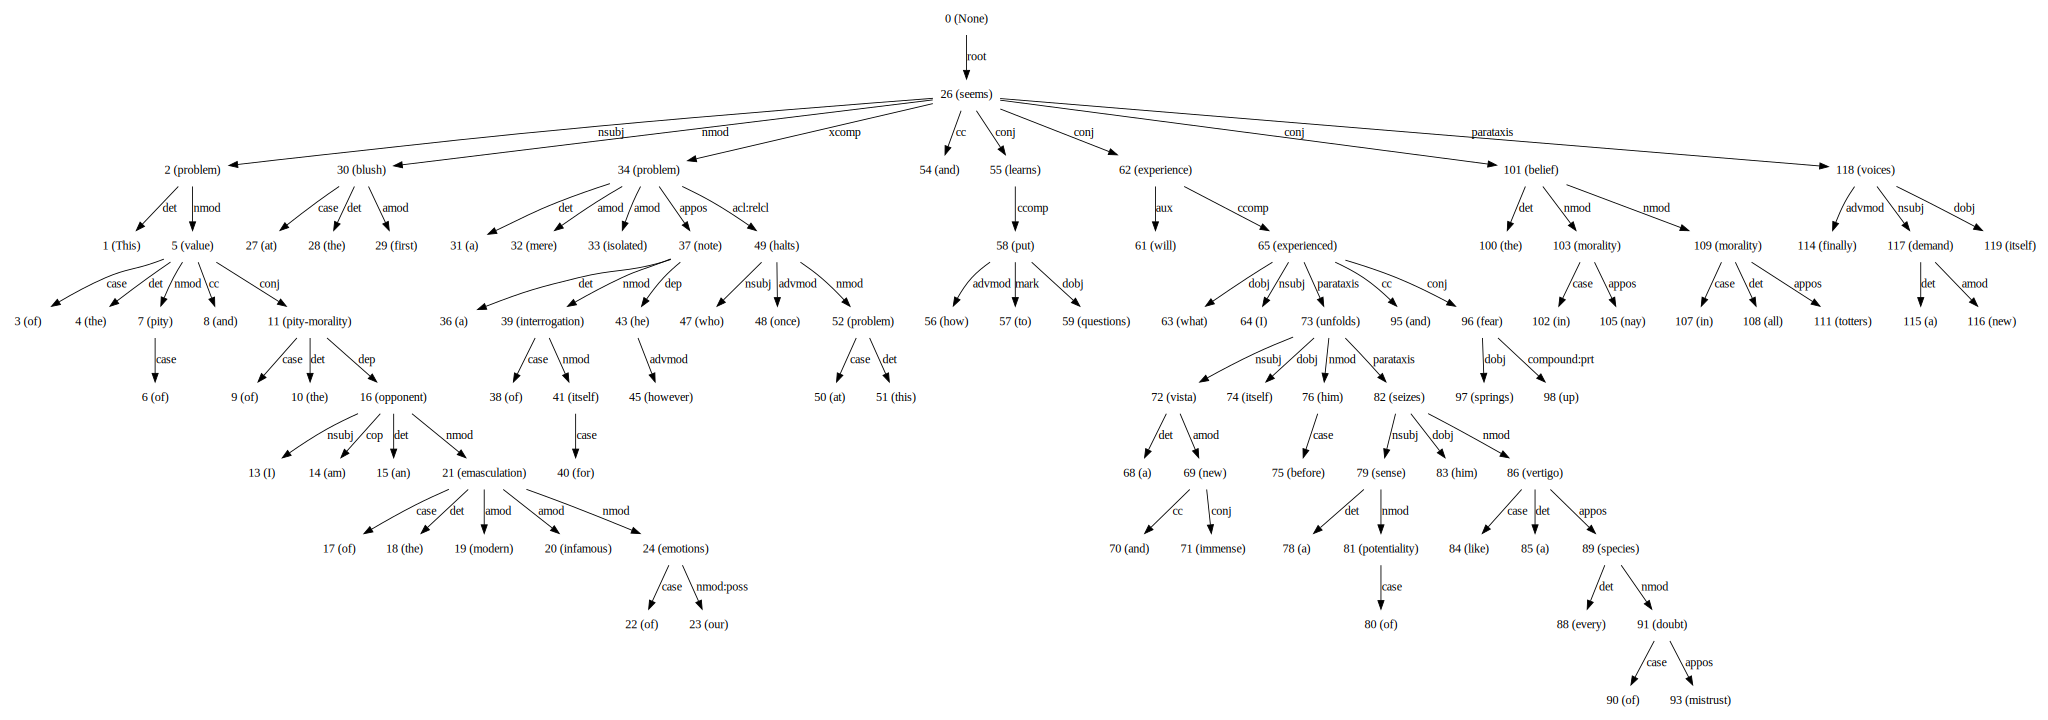

In [159]:
try:
    graph = graphviz.Source(list(topPostDepParse[targetSentence])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph

# Information extraction

Information extraction approaches typically (as here, with Stanford's Open IE engine) ride atop the dependency parse of a sentence. They are a pre-coded example of the type analyzed in the prior. 

In [160]:
ieDF = stanford.openIE(text)

Starting OpenIE run
Error: Could not find or load main class edu.stanford.nlp.naturalli.OpenIE
Caused by: java.lang.ClassNotFoundException: edu.stanford.nlp.naturalli.OpenIE



`openIE()` prints everything stanford core produces and we can see from looking at it that initializing the dependency parser takes most of the time, so calling the function will always take at least 12 seconds.

In [161]:
ieDF

,certainty,subject,verb,object


No buffalos (because there were no verbs), but the rest is somewhat promising. Note, however, that it abandoned the key theme of the sentence about the tragic Trayvon Martin death ("fatally shot"), likely because it was buried so deeply within the complex phrase structure. This is obviously a challenge. 

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">How would you extract relevant information about the Trayvon Martin sentence directly from the dependency parse (above)? Code an example here. (For instance, what compound nouns show up with what verb phrases within the sentence?) How could these approaches inform your research project?

Series([], Name: verb, dtype: object)

And we can also look for subject, object, target triples in one of the reddit stories.

In [48]:
ieDF = stanford.openIE(redditTopScores['text'][0])

Starting OpenIE run
Error: Could not find or load main class edu.stanford.nlp.naturalli.OpenIE
Caused by: java.lang.ClassNotFoundException: edu.stanford.nlp.naturalli.OpenIE



In [49]:
ieDF

,certainty,subject,verb,object


That's almost 200 triples in only:

In [50]:
len(redditTopScores['sentences'][0])

37

sentences and

In [51]:
sum([len(s) for s in redditTopScores['sentences'][0]])

971

words.

Lets find at the most common subject in this story.

In [52]:
ieDF['subject'].value_counts()

Series([], Name: subject, dtype: int64)

I is followed by various male pronouns and compound nouns (e.g., "old man"). 'I' occures most often with the following verbs:

In [53]:
ieDF[ieDF['subject'] == 'I']['verb'].value_counts()

Series([], Name: verb, dtype: int64)

and the following objects

In [54]:
ieDF[ieDF['subject'] == 'I']['object'].value_counts()

Series([], Name: object, dtype: int64)

We can also run the corenlp server. When you run this server (with the command below), you can click on the browswer link provided to experiment with it. Note that when we run the server, executing the command below, it interrupts the current jupyter process and you will not be able to run code here again (processes will "hang" and never finish) until you interrup the process by clicking "Kernel" and then "Interrupt".

In [ ]:
stanford.startCoreServer()

Starting server on http://localhost:16432 , please wait a few seconds


## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform open information extraction on a modest subset of texts relevant to your final project. Analyze the relative attachment of several subjects relative to verbs and objects and visa versa. Describe how you would select among these statements to create a database of high-value statements for your project and then do it by extracting relevant statements into a pandas dataframe.